In [1]:
import jittor as jt
import numpy as np
import matplotlib.pyplot as plt
from model import StyledGenerator, Discriminator
from dataset import SymbolDataset

[SYNC][i 0103 17:00:50.882413 00 compiler.py:847] Jittor(1.2.2.13) src: /home/xun18/.pyenv/versions/3.7-dev/lib/python3.7/site-packages/jittor
[SYNC][i 0103 17:00:50.883787 00 compiler.py:848] cache_path: /home/xun18/.cache/jittor/master/g++
[SYNC][i 0103 17:00:50.946723 00 __init__.py:250] Found gdb(8.1.0) at /usr/bin/gdb.
[SYNC][i 0103 17:00:50.957801 00 __init__.py:250] Found addr2line(2.30) at /usr/bin/addr2line.
[SYNC][i 0103 17:00:50.992360 00 compiler.py:897] pybind_include: -I/home/xun18/.pyenv/versions/3.7-dev/include/python3.7m -I/home/xun18/.pyenv/versions/3.7-dev/lib/python3.7/site-packages/pybind11/include
[SYNC][i 0103 17:00:51.008520 00 compiler.py:899] extension_suffix: .cpython-37m-x86_64-linux-gnu.so


[i 0103 17:00:50.872921 52 __init__.py:250] Found g++(7.5.0) at /usr/bin/g++.


[SYNC][i 0103 17:00:51.162666 00 __init__.py:169] Total mem: 12.35GB, using 4 procs for compiling.
[SYNC][i 0103 17:00:51.274461 00 jit_compiler.cc:21] Load cc_path: /usr/bin/g++
[SYNC][i 0103 17:00:51.434755 00 __init__.py:250] Found mpicc(2.1.1) at /usr/bin/mpicc.
[SYNC][i 0103 17:00:51.459937 00 compiler.py:654] handle pyjt_include/home/xun18/.pyenv/versions/3.7-dev/lib/python3.7/site-packages/jittor/extern/mpi/inc/mpi_warper.h
[SYNC][SYNC]

### Test Discriminator

In [2]:
netD = Discriminator()
nsteps = 5
alpha = 0
batch_size = 16
for step in range(nsteps):
    image_size = 2**(step+2)
    print('Testing image of [%02d x %02d]' % (image_size, image_size))
    image = jt.rand(batch_size, 3, image_size, image_size)
    pred = netD(image, step, alpha)
    assert(pred.shape == [batch_size, 1])

Testing image of [04 x 04]
Testing image of [08 x 08]
Testing image of [16 x 16]
Testing image of [32 x 32]
Testing image of [64 x 64]


### Test Generator

In [3]:
netG = StyledGenerator()
nsteps = 5
alpha = 0
batch_size = 16
code_dim = 512
z = jt.randn(batch_size, code_dim)

for step in range(nsteps):
    image_size = 2**(step+2)
    print('Testing image of [%02d x %02d]' % (image_size, image_size))
    fake_image = netG(z, step=step, alpha=alpha, style_weight=0.5)
    assert(fake_image.shape == [batch_size, 3, image_size, image_size])

Testing image of [04 x 04]
Testing image of [08 x 08]
Testing image of [16 x 16]
Testing image of [32 x 32]
Testing image of [64 x 64]


### Test Dataset

In [4]:
import jittor.transform as transform
transform = transform.Compose([
    #transform.Resize(size=img_size),
    transform.ToPILImage(),
    transform.RandomHorizontalFlip(),
    transform.ToTensor(),
    transform.ImageNormalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 32
root_path = 'color_symbol_7k'
train_loader = SymbolDataset(root_path, transform, 16).set_attrs(batch_size=batch_size, shuffle=True)

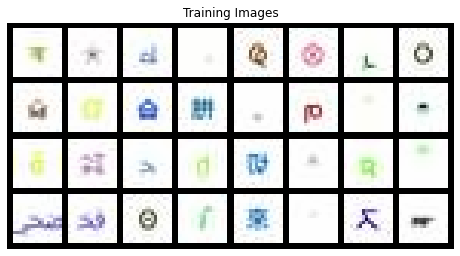

In [5]:
import torchvision.utils
import torch

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(torch.from_numpy(real_batch.numpy()), padding=2, normalize=True),(1,2,0)))

## Training

In [6]:
import math
import random

In [7]:
init_size = 8
code_size = 512
step = int(math.log2(init_size)) - 2
resolution = 4 * 2 ** step
train_loader = SymbolDataset(root_path, transform, resolution).set_attrs(batch_size=batch_size, shuffle=True)

disc_loss_val = 0
gen_loss_val = 0
grad_loss_val = 0

lr = 1e-3
alpha = 0
used_sample = 0
num_epoch = 5
mixing = True
phase = len(train_loader) * num_epoch

d_optimizer = jt.optim.Adam(netD.parameters(), lr=lr, betas=(0.0, 0.99))
g_optimizer = jt.optim.Adam(
        netG.generator.parameters(), lr=lr, betas=(0.0, 0.99)
    )
g_optimizer.add_param_group(
    {
        'params': netG.style.parameters(),
        'lr': lr * 0.01,
        'mult': 0.01,
    }
)

D_losses = []
G_losses = []

In [9]:
for epoch in range(num_epoch):
    
    for i, real_image in enumerate(train_loader):
        alpha = min(1, 1 / phase * (used_sample + 1))
        real_image.requires_grad = True
        real_scores = netD(real_image, step=step, alpha=alpha)
        real_predict = jt.nn.softplus(-real_scores).mean()
        #real_predict.backward(retain_graph=True)

        grad_real = jt.grad(real_scores.sum(), real_image)
        grad_penalty = (
            grad_real.reshape(grad_real.size(0), -1).norm(2, dim=1) ** 2
        ).mean()
        grad_penalty = 10 / 2 * grad_penalty
        #grad_penalty.backward()
        
        if mixing and random.random() < 0.9:
            gen_in11, gen_in12, gen_in21, gen_in22 = jt.randn(4, batch_size, code_size).chunk(4, 0)
            gen_in1 = [gen_in11.squeeze(0), gen_in12.squeeze(0)]
            gen_in2 = [gen_in21.squeeze(0), gen_in22.squeeze(0)]
        else:
            gen_in1, gen_in2 = jt.randn(2, batch_size, code_size).chunk(2, 0)
            gen_in1 = gen_in1.squeeze(0)
            gen_in2 = gen_in2.squeeze(0)
        
        fake_image = netG(gen_in1, step=step, alpha=alpha)
        fake_predict = netD(fake_image, step=step, alpha=alpha)
        fake_predict = jt.nn.softplus(fake_predict).mean()
        #fake_predict.backward()
        loss_D = real_predict + grad_penalty + fake_predict
        d_optimizer.step(loss_D)
        
        fake_image = netG(gen_in2, step=step, alpha=alpha)
        predict = netD(fake_image, step=step, alpha=alpha)
        loss_G = jt.nn.softplus(-predict).mean()
        g_optimizer.step(loss_G)
        
        used_sample += real_image.shape[0]
        
        if i % 50 == 0:
            print('[%d/%d][%04d/%d] Loss_D: %.4f\tLoss_G: %.4f'
                  % (epoch + 1, num_epoch, i, len(train_loader)//batch_size,
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())

[SYNC][w 0103 17:01:25.846804 00 grad.cc:214] grads[0] 'progression.0.conv1.0.conv.bias' doesn't have gradient. It will be set to zero: Var(0x561108faf290:1:2:1:i0:o1:s1,float32,progression.0.conv1.0.conv.bias,0x5611092f4800)[512,]
[SYNC][w 0103 17:01:25.848008 00 grad.cc:214] grads[1] 'progression.0.conv1.0.conv.weight_orig' doesn't have gradient. It will be set to zero: Var(0x5611090d1260:1:2:2:i1:o1:s0,float32,progression.0.conv1.0.conv.weight_orig,0)[512,256,3,3,]
[SYNC][w 0103 17:01:25.850126 00 grad.cc:214] grads[2] 'progression.0.conv1.0.conv.weight' doesn't have gradient. It will be set to zero: Var(0x56110956b770:2:2:1:i1:o1:s1,float32,progression.0.conv1.0.conv.weight,0x7f19861ea040)[512,256,3,3,]
[SYNC][w 0103 17:01:25.852352 00 grad.cc:214] grads[3] 'progression.0.conv2.0.conv.bias' doesn't have gradient. It will be set to zero: Var(0x561109119570:1:2:1:i0:o1:s1,float32,progression.0.conv2.0.conv.bias,0x5611092f4000)[512,]
[SYNC][w 0103 17:01:25.854219 00 grad.cc:214] grads

[1/5][0000/217] Loss_D: 6.4715	Loss_G: 8.6429



Compiling Operators(4/25) used: 2.31s eta: 12.1s 6/25) used: 3.34s eta: 10.6s 8/25) used: 4.36s eta: 9.27s 12/25) used: 5.38s eta: 5.83s 16/25) used:  7.4s eta: 4.16s 17/25) used: 8.42s eta: 3.96s 20/25) used: 9.44s eta: 2.36s 24/25) used: 10.5s eta: 0.436s 25/25) used: 11.5s eta:    0s 
[SYNC][w 0103 17:02:13.142870 00 grad.cc:214] grads[0] 'progression.0.conv1.0.conv.bias' doesn't have gradient. It will be set to zero: Var(0x56110ad2ee00:1:1:1:i1:o0:s0,float32,progression.0.conv1.0.conv.bias,0)[512,]
[SYNC][w 0103 17:02:13.145225 00 grad.cc:214] grads[1] 'progression.0.conv1.0.conv.weight_orig' doesn't have gradient. It will be set to zero: Var(0x56110c09d880:1:1:1:i1:o0:s0,float32,progression.0.conv1.0.conv.weight_orig,0)[512,256,3,3,]
[SYNC][w 0103 17:02:13.147522 00 grad.cc:214] grads[2] 'progression.0.conv1.0.conv.weight' doesn't have gradient. It will be set to zero: Var(0x56110bec3f20:1:1:1:i1:o0:s0,float32,progression.0.conv1.0.conv.weight,0)[512,256,3,3,]
[SYNC][w 0103 17:02

NameError: name 'b_size' is not defined